In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn import functional as F
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import pywt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.signal import butter, filtfilt, stft, correlate, convolve
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import scipy.io
from sklearn.metrics import confusion_matrix
from PIL import Image
from tempfile import TemporaryDirectory
import time

In [ ]:
# Given functions deep learning laboratory
def print_preformance_grid(Flag=False,Values=None):
    if Flag:
        headers=['Epoch', 'Batch', 'Train Loss', 'Train Recall', 'Test Loss', 'Test Recall']
        print('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*headers))
        line_width = len('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*headers))
        print('-' * line_width)
    if Values:
        print('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*Values))
        line_width = len('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*Values))
        print('-' * line_width)

def prepare_dataloaders(train:Dataset,test:Dataset,batch_size,num_workers=16):
        
        if isinstance(batch_size, list):
                train_loader = DataLoader(train,batch_size=batch_size[0], shuffle=True,num_workers=num_workers)
                test_loader = DataLoader(test,batch_size=batch_size[1], shuffle=False,num_workers=num_workers)
                
                return train_loader,test_loader
        
        train_loader = DataLoader(train,batch_size=batch_size, shuffle=True,num_workers=num_workers,drop_last=True)
        test_loader = DataLoader(test,batch_size=batch_size, shuffle=False,num_workers=num_workers,drop_last=True)

        return train_loader,test_loader

class Hyper_Params:
    def __init__(self, params_dict=None):
        if params_dict:
            self.params_dict = params_dict
        else:
            self.params_dict = {
    
                'i_break':None,
                'batch_size':None,
                'model_params':{},
                'train_transforms' : None,
                'test_transforms': None,
                'lines': None,
                'epochs': None,
                'lr':None,
                'momentum': None,
                'optimizer': None,
                'scheduler_step_size':None,
                'scheduler_gamma':None,
                'epoch_loss_train': [],
                'epoch_accuracy_train': [],
                'train_loss_record': [],
                'train_accuracy_record': [],
                'test_loss_record': [],
                'test_accuracy_record': [],
                'fig': None,
                'ax1': None,
                'ax2': None,
                'space': None,
                'num_workers' : None,
                }
    def __getattr__(self, attr):
        if attr in self.params_dict:
            return self.params_dict[attr]
        else:
            raise AttributeError(f"'Params' object has no attribute '{attr}'")
        
    def __setattr__(self, attr, value):
        if attr == 'params_dict':
            super().__setattr__(attr, value)
        else:
            self.params_dict[attr] = value
    def __getitem__(self, key):
        return self.params_dict[key]

def plot_perceptron_animation(X_test, iterations, setosa, versicolor, weights):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 9)
    scatter1 = ax.scatter(setosa[:, 0], setosa[:, 1], c='b', marker='o', label='setosa')
    scatter2 = ax.scatter(versicolor[:, 0], versicolor[:, 1], c='r', marker='x', label='versicolor')

    def plot_line(X,weights):
        x = []
        y = []
        slope = -(weights[2]/weights[1])/(weights[2]/weights[0])  
        intercept = -weights[2]/weights[1]
        for j in np.linspace(np.amin(X[:,0])-0.5,np.amax(X[:,0])+0.5):
            #y=mx+c, m is slope and c is intercept
            x.append(j)
            y.append((slope*j) + intercept)
            
        return x, y
   
    def animate(i,line, X, weights):
        
        x, y = plot_line(X,weights[:,i])
        line.set_data(x, y)
        return line
  

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    plt.title('Logistic Regression Decision Boundaries at Different Stages')
    line, = ax.plot([], [], lw=2)
    ani = FuncAnimation(fig, animate, frames=iterations,fargs=(line, X_test, weights), interval=100, repeat=True)
    ani.save('learning_process.gif', writer='pillow')
    

    
def plot_perceptron_line(X_test,iterations,setosa,versicolor,weights):    
    plt.figure(figsize=(15, 9))
    scatter1 = plt.scatter(setosa[:, 0], setosa[:, 1], c='b', marker='o', label='setosa')
    scatter2 = plt.scatter(versicolor[:, 0], versicolor[:, 1], c='r', marker='x', label='versicolor')

    x_min, x_max = X_test[:, 0].min() - 5, X_test[:, 0].max() + 5
    y_min, y_max = X_test[:, 1].min() - 5, X_test[:, 1].max() + 5
    
   
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    def create_custom_colormap():
        cmap = plt.get_cmap('Blues')  
        colors = cmap(np.linspace(0.5, 1, cmap.N))  
        new_cmap = LinearSegmentedColormap.from_list('darkening_colormap', colors)
        return new_cmap
    custom_cmap = create_custom_colormap()

    for i in range(iterations):
        color = custom_cmap(i / weights.shape[1])
        Z = (weights[0,i] * xx + weights[1,i] * yy + weights[2,i]).flatten()
        Z = 1 / (1 + np.exp(-Z))
        Z= Z.reshape(xx.shape)


        contour = plt.contour(xx, yy, Z, levels=[0.5], colors=[color], linestyles=['-'])
        
       
  
    handels = [scatter1,scatter2]
    labels = ['setosa','versicolor']
   
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handels,labels,loc='best')

    plt.title('Logistic Regression Decision Boundaries at Different Stages')
    plt.show()

def update_graph(fig,ax1,ax2,x,train_loss,test_loss,train_accuracy,test_accuracy,space,lines):
    plt.close(fig)
    clear_output()
    plt.figure(fig)
    ax1.clear()
    ax1.set_title("Accuracy")
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(space))
    ax1.plot(x, np.array(train_accuracy)*100,color = "green", label='Train')
    ax1.plot(x, np.array(test_accuracy)*100,color = "black",linestyle='dashed', label='Test',marker='o')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('iteration')
    ax1.set_xlim(left = int(-0.2*space))
    ax1.set_ylim(top = 100)
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(10))
    ax1.grid(color = 'gray',which='both', axis='y', linestyle='--', linewidth=0.5)
    x_values = range(0, int(x[-1])+1, lines)
    for t in x_values:
        ax1.axvline(x=t, color='cyan', linestyle='--', linewidth=0.5)
    ax1.legend(loc='lower right',fontsize= 'x-large')

    ax2.clear()
    ax2.set_title("Loss")
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(space))
    ax2.plot(x, train_loss,color = "red", label='Train')
    ax2.plot(x, test_loss,color = "black",linestyle='dashed', label='Test',marker='o')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('iteration')
    ax2.set_xlim(left = int(-0.2*space))
    ax2.legend(loc='upper right',fontsize= 'x-large')
    
    for t in x_values:
        ax2.axvline(x=t, color='cyan', linestyle='--', linewidth=0.5)
    fig.tight_layout(pad=2.0)
    plt.draw()  
    plt.pause(0.00000001)

def  display_Mnist1(train):
    from mpl_toolkits.axes_grid1 import ImageGrid
   
    samples =[]
    for i in range(16):
        samples.append(train.__getitem__(i)[0])

    fig = plt.figure(figsize=(8,8))
    grid = ImageGrid(fig,111,nrows_ncols=(4,4),axes_pad=0.1)
    for ax,im in zip(grid,samples):
        ax.imshow(im,cmap='Greys_r') # look at matplotlib colormaps for more options 

def print_performance(epoch,i,model_params:Hyper_Params,test_loss,test_accuracy):
    model_params.train_loss_record.append(np.sum(model_params.epoch_loss_train) / (i + 1))
    model_params.train_accuracy_record.append(np.sum(model_params.epoch_accuracy_train) / (i + 1))
    model_params.test_loss_record.append(test_loss)
    model_params.test_accuracy_record.append(test_accuracy)
    values = [epoch + 1 if i>0 else epoch, i + 1 if i>0 else i, round(model_params.train_loss_record[-1], 2), round(model_params.train_accuracy_record[-1], 2),
              np.round(test_loss, 2), np.round(test_accuracy, 2)]
    
    print_preformance_grid(Values=values)
    update_graph(model_params.fig, model_params.ax1, model_params.ax2, np.arange(len(model_params.train_loss_record))*min(model_params.iter_break,model_params.lines), model_params.train_loss_record, model_params.test_loss_record,
    model_params.train_accuracy_record, model_params.test_accuracy_record,model_params.space,model_params.lines)
    return

def multi_class_accuracy(outputs, targets):

    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

def evaluate_model(model:nn.Module,test_loader,criion,acc_function):
    
    if isinstance(test_loader,DataLoader):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        Test_accuracy = []
        Test_loss = []
        with torch.no_grad():
            model.eval()
            for j,batch in enumerate(test_loader):
                data,target = batch
                
                output = model(data.to(device))
                target = target.reshape(target.shape[0])
                loss = criion(output,target.to(device))
                
                accuracy = acc_function(output,target.to(device))
                
                Test_accuracy.append(accuracy)
                Test_loss.append(loss.item())
        return np.mean(Test_loss),np.mean(Test_accuracy)
    data,target = test_loader        
    output = model(data.to(device))
    target = target.reshape(target.shape[0])
    loss = criion(output,target.to(device))
    
    accuracy = acc_function(output,target.to(device))
    
    return loss.item(),accuracy

def present_confusion_matrix(model:nn.Module,test_loader:DataLoader,n_class,class_dict, is_train=True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    y_true = []
    y_pred = []
    with torch.no_grad():
        model.eval()
        for j,batch in enumerate(test_loader):
                data,target = batch
                
                outputs = model(data.to(device)) 
                _, predicted = torch.max(outputs, 1)  

                y_pred.extend(list(predicted.cpu().numpy()))  
                y_true.extend(list(target.cpu().numpy()))
    class_names = [class_dict[i] for i in range(len(class_dict))]
    conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
    if is_train:
        data_type = 'Train'
    else:
        data_type = 'Test'
    plt.figure(figsize=(15, 9))
    
    plt.imshow(conf_matrix , cmap='Blues', interpolation='nearest', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.title(f'{data_type} Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(class_dict)), class_names)
    plt.yticks(np.arange(len(class_dict)), class_names)
    for i in range(n_class):
        for j in range(n_class):
            plt.text(j, i, f'{conf_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=14)
    plt.show() 

def layers_to_optimize(model:torchvision.models.vgg16,num:int,p1=0.5,p2=0.5,output_size = 6):
    if num not in [1,2,3]:
        print("error: selected either too many or too few linear layers")
        return None
    for param in model.parameters():
        param.requires_grad = False

    if num == 1:
        num_ftrs = model.classifier[6].in_features 
        model.classifier[6] = nn.Linear(num_ftrs, output_size)

    if num == 2:
        num_ftrs1 = model.classifier[3].in_features
        num_ftrs2 = model.classifier[6].in_features 
        model.classifier[3] = nn.Linear(num_ftrs1, num_ftrs2)
        model.classifier[4] = nn.ReLU(inplace=False)
        model.classifier[5] = nn.Dropout(p=p1, inplace=False)
         
        model.classifier[6] = nn.Linear(num_ftrs2, output_size)
    if num == 3:
        num_ftrs = model.classifier[0].in_features
        num_ftrs1 = model.classifier[3].in_features
        num_ftrs2 = model.classifier[6].in_features 

        model.classifier[0] = nn.Linear(num_ftrs, num_ftrs1)
        model.classifier[1] = nn.ReLU(inplace=False)
        model.classifier[2] = nn.Dropout(p=p1, inplace=False)
        model.classifier[3] = nn.Linear(num_ftrs1, num_ftrs2)
        model.classifier[4] = nn.ReLU(inplace=False)
        model.classifier[5] = nn.Dropout(p=p2, inplace=False)
         
        model.classifier[6] = nn.Linear(num_ftrs2, output_size)
    return model

def print_deserts(train):
    dataloader = DataLoader(train,batch_size=16, shuffle=True,num_workers=4)
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    class_names = {0:"canoli", 1:"moose", 2:"churros",3:"creme brule", 4:"cupcake", 5:"doughnuts" } 


    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.6)  

    for i, ax in enumerate(axes.flat):
        # Display image
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.axis('off') 

        
        label_index = labels[i].item()
        label_name = class_names[label_index]
        ax.set_title(label_name, fontsize=10, color='blue')


    plt.show()

def display_mislabaled(model,train_loader,mean,std):    
    
    imagenet_classes={}
    with open("imagenet_classes.txt") as f:
        for line in f:
            (key, val) = line.split(sep=":")
            imagenet_classes[int(key)] = val

    model.eval()

    batch = next(iter(train_loader))

    with torch.no_grad():
        data,_ = batch
        output = model(data)
        _,labels =  torch.max(output, 1)
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.6)  
    # denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))
    for i, ax in enumerate(axes.flat):
        # Display image
        image = batch[0][i]
        image[0] = image[0]*std[0]+mean[0]
        image[1] = image[1]*std[1]+mean[1]
        image[2] = image[2]*std[2]+mean[2]
        image = image.permute(1, 2, 0)
        ax.imshow(image)
        ax.axis('off') 

        
        label_index = labels[i].item()
        label_name = imagenet_classes[label_index]
        ax.set_title(label_name, fontsize=10, color='blue')
        
    plt.show()

In [5]:
def decimate(sig, ratio):
    return sig[::ratio]

In [6]:
def show_stft_info(signal, label, class_dict):

    f, t, Zxx = stft(signal, 1e3, window='hann', nperseg=64, noverlap=60)
    print(Zxx.shape)

    zxx_flattened = Zxx.flatten()
    selected_elements = zxx_flattened[:100]

    rows, cols = np.unravel_index(np.arange(100), Zxx.shape)
    selected_frequencies = f[np.unique(rows)]
    class_of_signal = class_dict[int(label/2)]

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title(f'STFT Magnitude - Signal is {class_of_signal}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Magnitude')

    plt.scatter(t[cols], f[rows], c=np.abs(selected_elements), 
    cmap='viridis', edgecolor='k', label='Selected Points')

    plt.legend()
    plt.show()

    freq_min = selected_frequencies.min()
    freq_max = selected_frequencies.max()
    print(f"The selected elements correspond to frequencies in the range: {freq_min} Hz to {freq_max} Hz.")
    return None


In [7]:
def signal_stft(signal):

    f, t, Zxx = stft(signal, 1e3, window='hann', nperseg=64, noverlap=60)
    Zxx = Zxx.flatten()
    return Zxx[:80] #    return Zxx[:100]


In [8]:
def cross_corr(X, y):
    N=8
    X = (1/N)*convolve(X, np.ones((N)), 'same')
    y = (1/N)*convolve(y, np.ones((N)), 'same')
    cross_corr = np.correlate(X, y, mode='same')

    norm_cross_corr = cross_corr / (np.linalg.norm(X) * np.linalg.norm(y))
    return norm_cross_corr

In [9]:
def corr_set(X, y):
    corr_data = []
    for i in range(len(X)):
        cc = cross_corr(X[i], y[i])
        corr_data.append(cc)
    return torch.Tensor(corr_data)

In [10]:
def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = filtfilt(b, a, data, padlen=2)
#     return -y

def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    trim_time = 10e-3  # seconds
    trim_samples = int(fs * trim_time)
    y = data[trim_samples: -trim_samples]
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, y, padlen=2)
    return -y

In [11]:
def get_set_stft(X):
    freq_data = []
    for i in range(len(X)):
        stft_X = signal_stft(X[i]) 
        freq_data.append(stft_X)
    return torch.Tensor(freq_data)

In [12]:
def filter_set(X):
    filtered_data = []
    for i in range(len(X)):
        data = decimate(X[i], 10)
        filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=5)
        filtered_data.append(filtered_X)
    return torch.Tensor(filtered_data)

In [ ]:
def filter_set_aug(X,y):
    filtered_data = []
    labels = []
    for i in range(len(X)):
        data = decimate(X[i], 10)
        filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=5)
        filtered_data.append(filtered_X)
        labels.append(y[i])
        if y[i]/2 == 1:
            data = decimate(X[i], 10)
            filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=5)*1.1
            filtered_data.append(filtered_X)
            labels.append(y[i])

            data = decimate(X[i], 10)
            filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=5)*1.05
            filtered_data.append(filtered_X)
            labels.append(y[i])

            data = decimate(X[i], 10)
            filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=3)
            filtered_data.append(filtered_X)i 
            labels.append(y[i])

            data = decimate(X[i], 10)
            filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=3)*1.1
            filtered_data.append(filtered_X)
            labels.append(y[i])

            data = decimate(X[i], 10)
            filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=3)*1.05
            filtered_data.append(filtered_X)
            labels.append(y[i])

    return torch.Tensor(filtered_data), torch.Tensor(labels)

In [14]:
def evaluate(test_loader,model,criterion,acc_function):
    with torch.no_grad():
        loss = 0
        acc = 0
        for i,batch in enumerate(test_loader):
            data,target = batch
            output = model(data.to(device))
            batch_loss = criterion(output,((target).long()).to(device))
            
            batch_acc = acc_function(output,target.to(device))

            loss+= batch_loss
            acc+=batch_acc
        return loss.item()/len(test_loader),acc/len(test_loader)

In [15]:
def create_augmantations(X, y, c):
    mean = 0
    std = 5e-6
    num_samples = 1000
    Xcopy = X.copy(deep=True)
    Xcopy.insert(0, 'label', y)
    X1 = (Xcopy[y/2 == c])
    
    X1=X1.reindex(index=np.arange(0, len(X1)), method='nearest')
       
    for sample in range(len(X1)):
        new_values = X1['values'][sample]
        new_bl = X1['baseline_values'][sample]
        id = X1['surgery_id'][sample]
        ch = X1['channel'][sample]
        timestamp = X1['timestamp'][sample]
        agreement = X1['label_agreement'][sample]
        bl_label = X1['baseline_label'][sample]
        bl_agreement = X1['baseline_agreement'][sample]
        label = X1['label'][sample]
        rate = 10e4
        df = pd.DataFrame({"label":label, "surgery_id":id, "channel": ch, 
                           "timestamp":timestamp, "baseline_values":[new_bl], "signal_rate":rate, 
                           "values":[new_values], "label_agreement":agreement,
                            "baseline_label":bl_label, "baseline_agreement":bl_agreement})
        X1 = pd.concat([X1, df], ignore_index = True)

    return X1

In [16]:
def create_uniform_data(X, y):
    Xcopy = X.copy(deep=True)
    Xcopy.insert(0, 'label', y)
    X0 = (Xcopy[y/2 == 0]).sort_values(by='label_agreement', ascending=False)
    X0 = X0[0:1784]
    X1 = ((Xcopy[y/2 == 1])).sort_values(by='label_agreement', ascending=False)
    X1 = X1[0:1784]
    X2 = (Xcopy[y/2 == 2]).sort_values(by='label_agreement', ascending=False)
    X2 = X2[0:1784]
    X3 = (Xcopy[y/2 == 3]).sort_values(by='label_agreement', ascending=False)
    X3 = X3[0:1784]
    print(':)')

    Xuni = pd.concat([X0, X1, X2, X3], ignore_index=1)
    yuni = Xuni['label']
    Xuni_data = Xuni.drop('label', axis=1)
    return Xuni_data, yuni


In [17]:
def create_uniform_data_w_aug(X, y):
    Xcopy = X.copy(deep=True)
    Xcopy.insert(0, 'label', y)
    X0 = (Xcopy[y/2 == 0]).sort_values(by='label_agreement', ascending=False)
    X0 = X0
    X1 = ((Xcopy[y/2 == 1])).sort_values(by='label_agreement', ascending=False)
    X1 = create_augmantations(X, y, c=1)
    X2 = (Xcopy[y/2 == 2]).sort_values(by='label_agreement', ascending=False)
    X2 = X2
    X3 = (Xcopy[y/2 == 3]).sort_values(by='label_agreement', ascending=False)
    X3 = X3
    print(':)')

    Xuni = pd.concat([X0, X1, X2, X3], ignore_index=1)
    yuni = Xuni['label']
    Xuni_data = Xuni.drop('label', axis=1)
    return Xuni_data, yuni


In [18]:
def create_semi_uniform_data(X, y):
    Xcopy = X.copy(deep=True)
    Xcopy.insert(0, 'label', y)
    X0 = (Xcopy[y/2 == 0]).sort_values(by='label_agreement', ascending=False)
    X0 = X0[0:9245]
    X1 = ((Xcopy[y/2 == 1])).sort_values(by='label_agreement', ascending=False)
    X1 = X1[0:1784*3]
    X2 = (Xcopy[y/2 == 2]).sort_values(by='label_agreement', ascending=False)
    X2 = X2[0:7245]
    X3 = (Xcopy[y/2 == 3]).sort_values(by='label_agreement', ascending=False)
    X3 = X3[0:2835]
    print(':)')

    Xuni = pd.concat([X0, X1, X2, X3], ignore_index=1)
    yuni = Xuni['label']
    Xuni_data = Xuni.drop('label', axis=1)
    return Xuni_data, yuni


In [ ]:
def train_with_scheduler(hparams,train_loader:DataLoader,test_loader,model:nn.Module,optimizer:torch.optim,scheduler:torch.optim.lr_scheduler,criterion,acc_function):
    hparams.fig, (hparams.ax1, hparams.ax2) = plt.subplots(2, 1, figsize=(15, 9)) 
    print_preformance_grid(Flag=True)
      
    for epoch in range(hparams.epochs):
        model.train()
        hparams.epoch_accuracy_train = np.zeros(len(train_loader))
        hparams.epoch_loss_train = np.zeros(len(train_loader))
      
        for i,batch in enumerate(train_loader): 
            optimizer.zero_grad() 
            data,target = batch
            target = target.reshape(target.shape[0]).to(device)
             
            output = model(data.to(device)) 
            loss = criterion((output),(target).long())
            accuracy = acc_function(output,target.to(device))
            
            loss.backward()
            optimizer.step() 
               
            hparams.epoch_accuracy_train[i] = accuracy
            hparams.epoch_loss_train[i] = loss.item()
                
            if (i==0 and epoch ==0) or (i+1) % hparams.iter_break==0:
                torch.cuda.empty_cache()
                model.eval()
                test_loss,test_accuracy = evaluate(test_loader,model,criterion,acc_function)
                print_performance(epoch,i,hparams,test_loss,test_accuracy)
                model.train()

        scheduler.step()

    plt.show()

In [ ]:
# Setting fixed seeds
seed = 48 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
# Hyper Parameters
hparams = Hyper_Params()
hparams.momentum = 0.9
hparams.weight_decay = 0
hparams.dropout_probability = 0
hparams.lr = 2e-5 
hparams.epochs = 30
hparams.batch_size = 57
hparams.scheduler_step_size = 30
hparams.scheduler_factor = 0.2
hparams.iter_break = 100
hparams.space = 150
hparams.lines = 200
hparams.num_workers = 16

In [ ]:
# Classes and opening dataset
with open('SSEPLowerDataLabeled.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
X,y,X_test,y_test = loaded_data['X'],loaded_data['y'],loaded_data['X_test'], loaded_data['y_test']

class_dict = {0:'no response', 1:'significant drop', 2:'normal response', 3:'technical'}

In [ ]:
# Basic project A filters
filtered_X_train, y_aug = filter_set_aug(X['values'], y)
stft_X_train = get_set_stft(filtered_X_train)
filtered_X_test = filter_set(X_test['values'])
stft_X_test = get_set_stft(filtered_X_test)

In [ ]:
# Applying filters onto baselines
aug_num_1 = 5

def filter_set_base(X,base_labels,y):
    filtered_data = []
    bsl = []
    for i in range(len(X)):
        data = decimate(X[i], 10)
        filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=5)
        filtered_data.append(filtered_X)
        bsl.append(base_labels[i])
        if y[i]/2 == 1:
            data = decimate(X[i], 10)
            filtered_X = butter_bandpass_filter(data, 30, 250, 1e3, order=5)
            
            j=0
            while j < aug_num_1:
                filtered_data.append(filtered_X)
                bsl.append(base_labels[i])
                j = j + 1
        
    return torch.Tensor(filtered_data), torch.Tensor(bsl)



In [ ]:
# Setting up the channels
filtered_baseline_train, bsl = filter_set_base(X['baseline_values'],X['baseline_label'],y)
stft_baseline_train = get_set_stft(filtered_baseline_train)

filtered_baseline_test = filter_set(X_test['baseline_values'])
stft_baseline_test = get_set_stft(filtered_baseline_test)

diff_train = np.abs(filtered_X_train - filtered_baseline_train)
diff_test = np.abs(filtered_X_test - filtered_baseline_test)

full_train_set = torch.stack((filtered_X_train, filtered_baseline_train, stft_X_train, diff_train), axis=1)
full_test_set = torch.stack((filtered_X_test, filtered_baseline_test, stft_X_test, diff_test), axis=1)

full_train_set_labeled = TensorDataset(full_train_set, torch.div(y_aug, 2))
full_test_set = TensorDataset(full_test_set, torch.Tensor(y_test.values/2))

In [ ]:
# Defining Network using SSEP Blocks
class SSEPBlock(nn.Module):
    def __init__(self,input_size,output_size):
        super(SSEPBlock,self).__init__()

        self.Block = nn.Sequential(nn.Conv1d(in_channels=input_size,out_channels=output_size, kernel_size=3, padding=1, padding_mode='zeros'), 
                                 nn.GroupNorm(num_groups=4, num_channels=output_size) ,
                                 nn.ReLU(inplace=True), 
                                 nn.Conv1d(in_channels=output_size,out_channels=output_size, kernel_size=3, padding=1, padding_mode='zeros'), 
                                 nn.GroupNorm(num_groups=4, num_channels=output_size) , 
                                 nn.ReLU(inplace=True), 
                                 nn.MaxPool1d(2)
        ) 
        
    def forward(self,x):
        return self.Block(x)

In [ ]:
class SSEPClassifier(nn.Module):
    def __init__(self,input_size:tuple,channels:list,hidden_dim:list,output_size:int,p=0):
        super(SSEPClassifier,self).__init__()
        self.ssepblocks = nn.Sequential(SSEPBlock(input_size[0],channels[0]),
                                      SSEPBlock(channels[0],channels[1]),
                                      SSEPBlock(channels[1],channels[2]),
                                      SSEPBlock(channels[2],channels[3]))
 
        # Define a dropout layer with probability p - maybe use later
        self.dropout = nn.Dropout(p)
        self.linear1 = nn.Linear(channels[3] * (input_size[1] // (2 ** len(channels))), hidden_dim[0])
        self.linear2 = nn.Linear(hidden_dim[0], output_size)
        self.flatten = nn.Flatten()
     
      
    def forward(self,x):
        z1 = self.ssepblocks(x)
        z2 = self.dropout(z1)
        z3 = self.flatten(z2) 
        z4 = self.linear1(z3)
        out = self.linear2(z4)
   
        return out

In [ ]:
# Define the model, optimizer, loss criterion and Scheduler and Data loaders
model = SSEPClassifier(input_size=(4,80,hparams.batch_size),channels=[512,256,128,64],hidden_dim=[16],output_size=4,p=hparams.dropout_probability).to(device) 
optimizer = optim.Adam(model.parameters(), lr=hparams.lr, weight_decay=hparams.weight_decay)
counts = torch.tensor([9245, 1784, 15425, 2835], dtype=torch.float)
total = counts.sum()
weights = total/counts
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
scheduler = optim.lr_scheduler.StepLR(optimizer, hparams.scheduler_step_size, hparams.scheduler_factor, verbose=False) 
train_loader = DataLoader(full_train_set_labeled,  batch_size=hparams.batch_size, num_workers=16, shuffle=True)
test_loader = DataLoader(full_test_set, batch_size=hparams.batch_size, num_workers=16, shuffle=True)


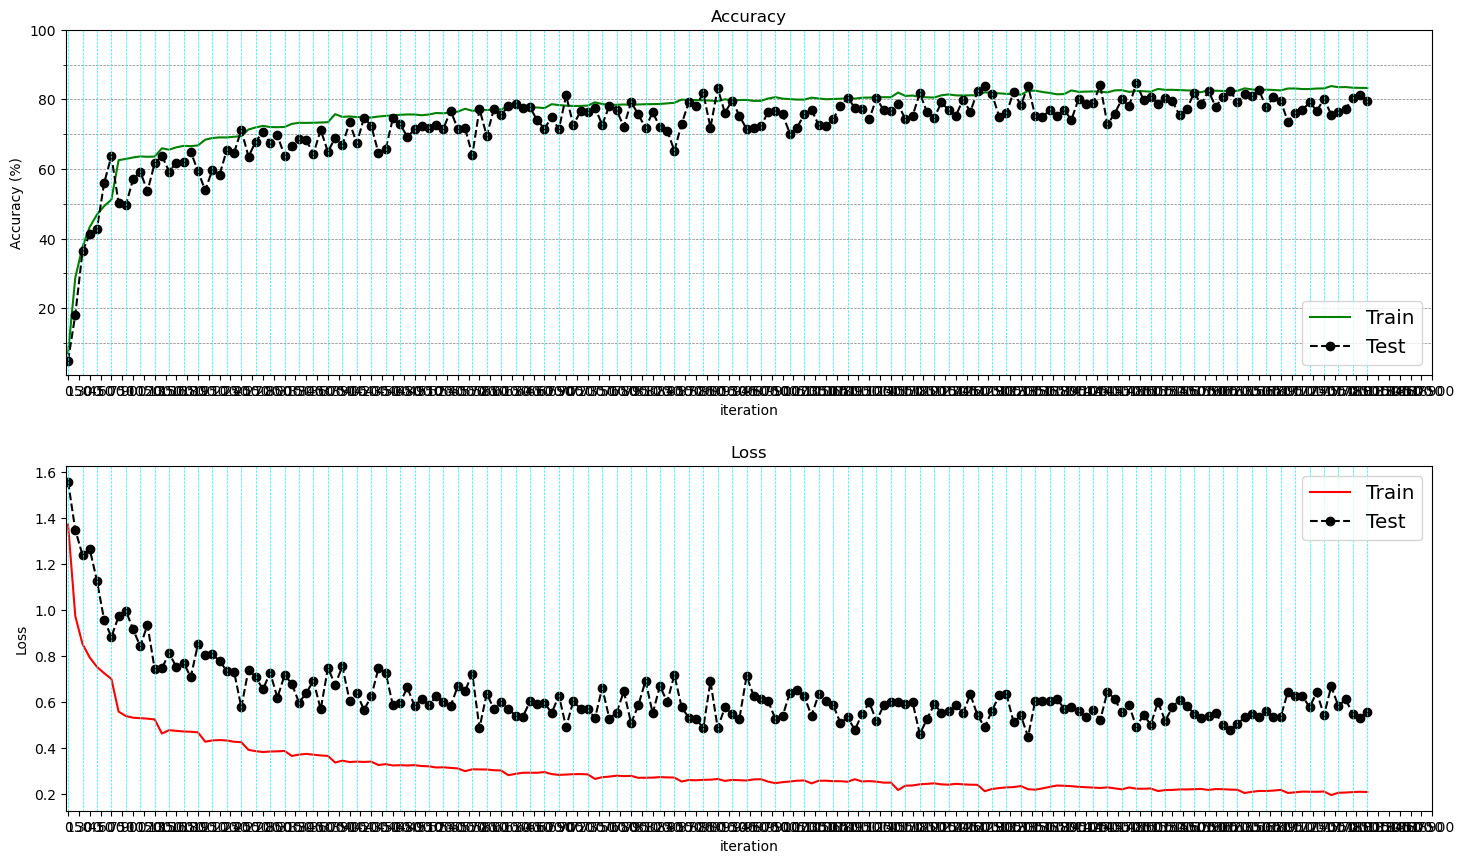

In [ ]:
# First iteration - only labeled data
train_with_scheduler(hparams=hparams,train_loader=train_loader,test_loader=test_loader,model=model,optimizer=optimizer,scheduler=scheduler,criterion=criterion,acc_function=multi_class_accuracy)# to full writ
torch.save(model.state_dict(), 'semi_supervised.pt') # save with name adjusments

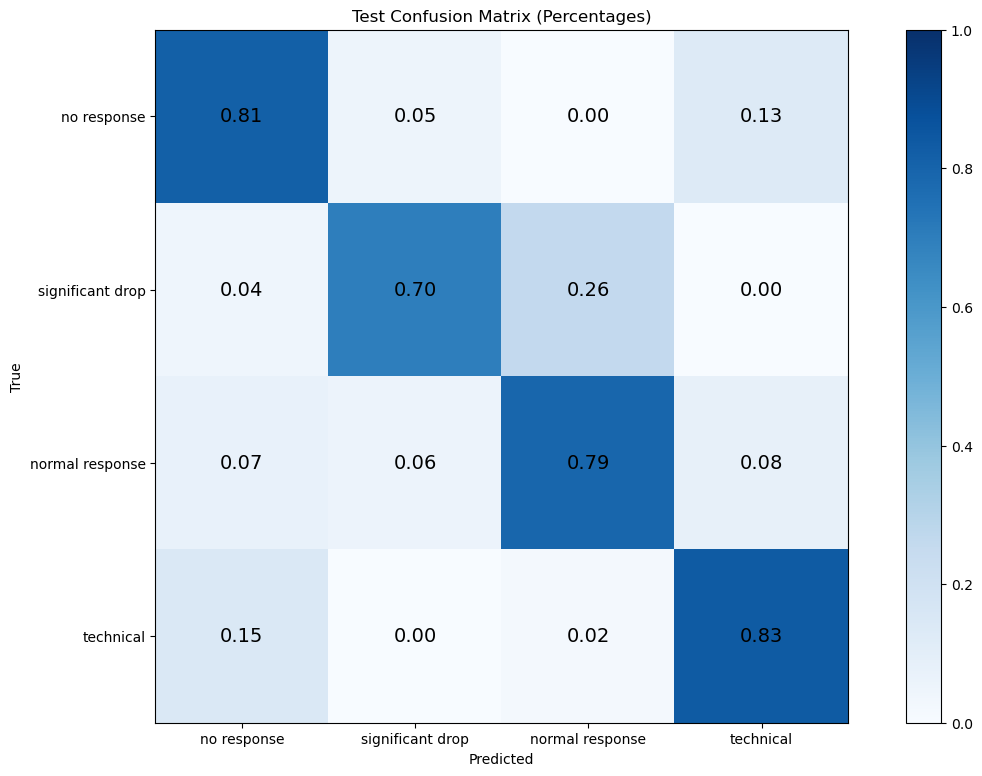

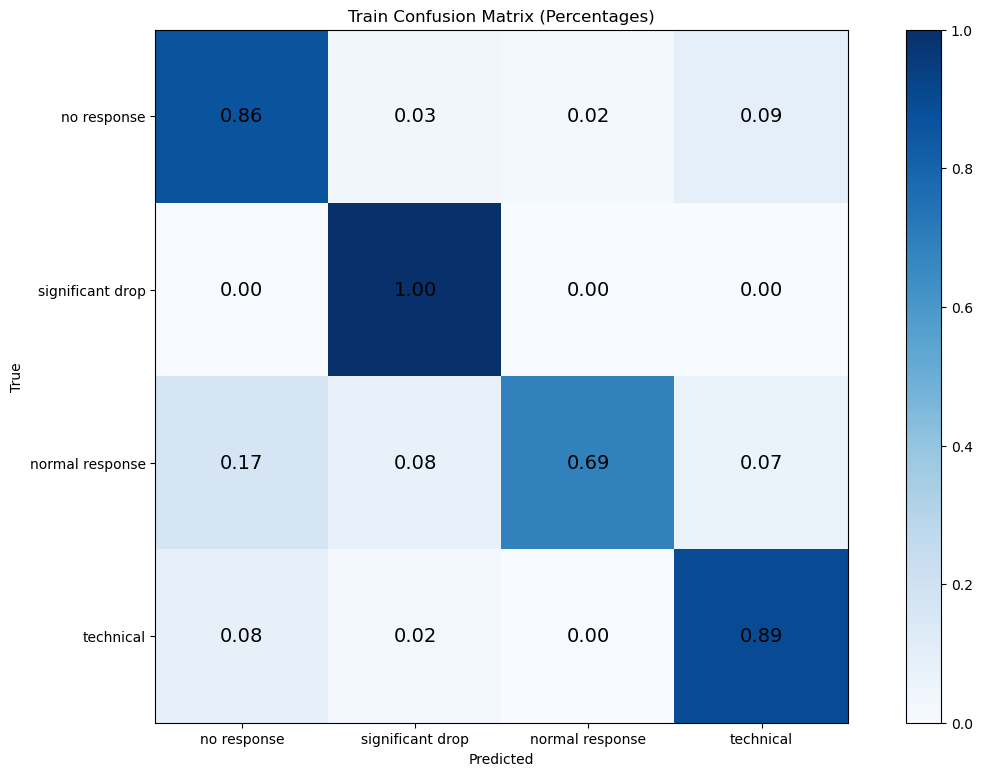

In [ ]:
# Confusion matrix for first iteration
model.load_state_dict(torch.load('semi_supervised.pt'))
present_confusion_matrix(model,test_loader, 4, class_dict, is_train=False)
present_confusion_matrix(model,train_loader, 4, class_dict, is_train= True)

In [ ]:
# Concatenating unlabeled data we classify with high confidence to labeled data
model.load_state_dict(torch.load('semi_supervised.pt'))
loaded_unlabeled_data = pd.read_pickle('SSEPLowerDataUnlabeled.pkl')
filtered_X_unlabeled = filter_set(loaded_unlabeled_data['values'].values)
filtered_baseline_unlabeled = filter_set(loaded_unlabeled_data['baseline_values'].values)
stft_unlabeled = get_set_stft(filtered_X_unlabeled)
diff_ulabeled = np.abs(filtered_X_unlabeled - filtered_baseline_unlabeled)
full_unlabeled_set = torch.stack((filtered_X_unlabeled, filtered_baseline_unlabeled, stft_unlabeled, diff_ulabeled), axis=1)

unlabeled_loader = DataLoader(full_unlabeled_set, batch_size=hparams.batch_size,num_workers=16)

threshold = 0.95
predicted_labels = []
samples = []

model.eval()
for batch in unlabeled_loader:
    batch = batch.to(device)
    output = model(batch)
    confidence, labels = torch.max(output, dim=1)
    # Filter by threshold
    high_conf_indices = (confidence > threshold).nonzero(as_tuple=True)[0]
    high_conf_labels = labels[high_conf_indices]
    high_conf_samples = batch[high_conf_indices]
    
    samples.append(high_conf_samples)
    predicted_labels.append(high_conf_labels)


In [ ]:
samples = torch.cat(samples, dim=0).cpu()
predicted_labels = torch.cat(predicted_labels, dim=0).cpu()
full_train_set = torch.stack((filtered_X_train, filtered_baseline_train, stft_X_train, diff_train), axis=1)
full_train_set = torch.cat((full_train_set, samples), axis=0)
y_full = torch.cat((torch.div(y_aug,2), predicted_labels), axis=0)
full_train_set_labeled = TensorDataset(full_train_set, y_full)

In [ ]:
# Define the model, optimizer, loss criterion and Scheduler and Data loaders
model = SSEPClassifier(input_size=(4,80,hparams.batch_size),channels=[512,256,128,64],hidden_dim=[16],output_size=4,p=hparams.dropout_probability).to(device) 
optimizer = optim.Adam(model.parameters(), lr=hparams.lr, weight_decay=hparams.weight_decay)
counts = torch.tensor([9245, 1784, 15425, 2835], dtype=torch.float)
total = counts.sum()
weights = total/counts
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
scheduler = optim.lr_scheduler.StepLR(optimizer, hparams.scheduler_step_size, hparams.scheduler_factor, verbose=False) 
train_loader = DataLoader(full_train_set_labeled,  batch_size=hparams.batch_size, num_workers=16, shuffle=True)
test_loader = DataLoader(full_test_set, batch_size=hparams.batch_size, num_workers=16, shuffle=True)

In [ ]:
# Number of samples the model predicted
print(samples.shape)  

torch.Size([7104, 4, 80])


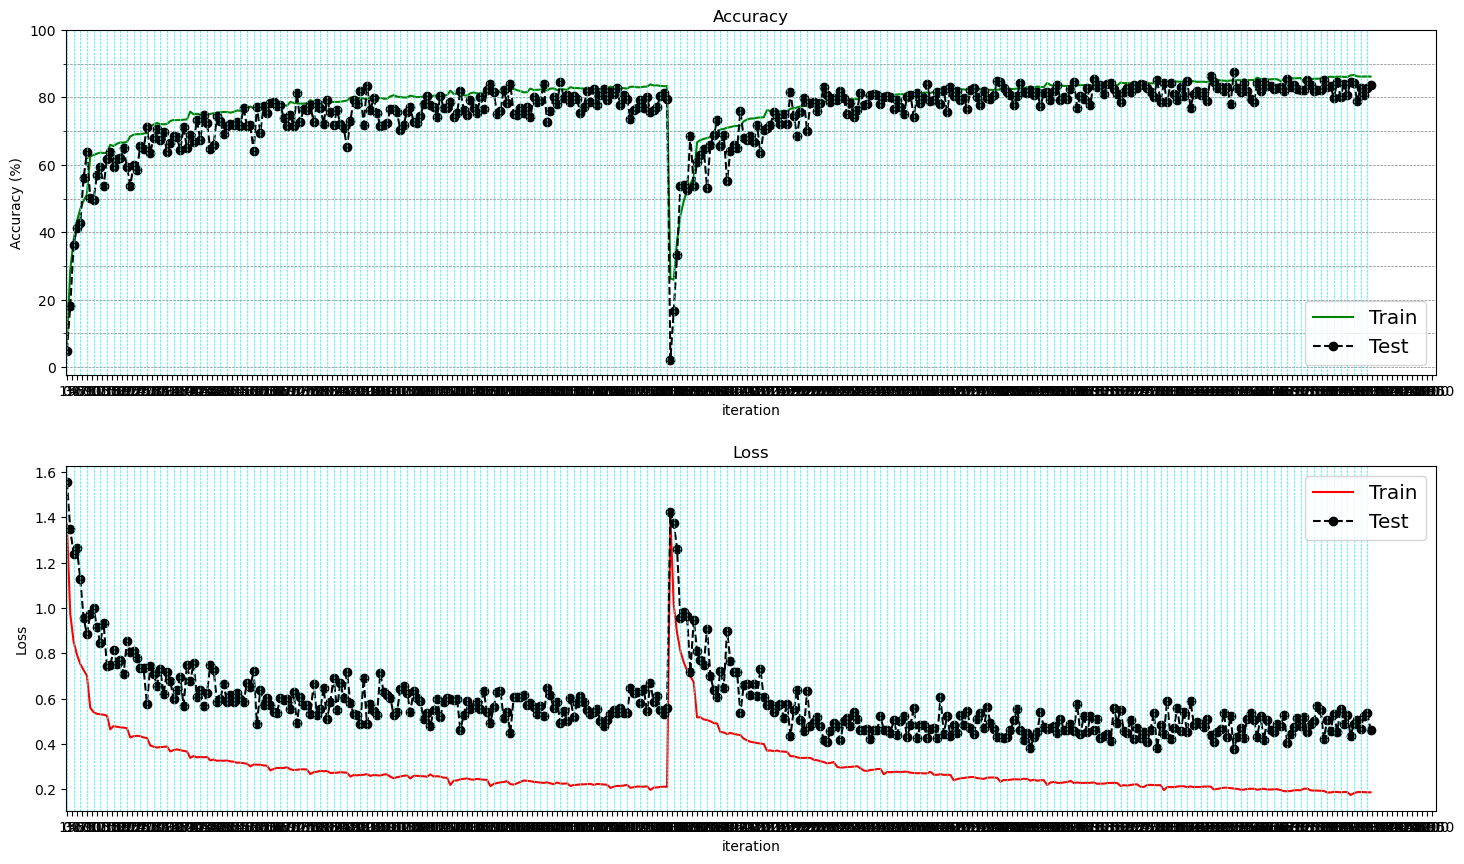

In [ ]:
# Second iteration - both unlabeled and labeled data
train_with_scheduler(hparams=hparams,train_loader=train_loader,test_loader=test_loader,model=model,optimizer=optimizer,scheduler=scheduler,criterion=criterion,acc_function=multi_class_accuracy)# to full writ

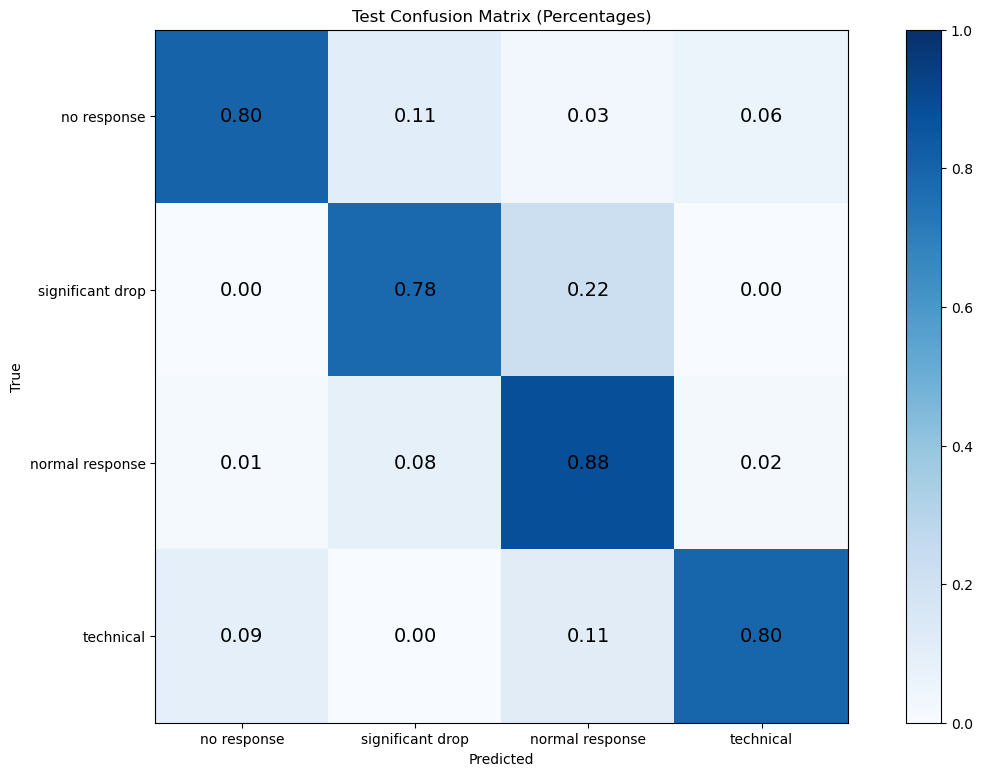

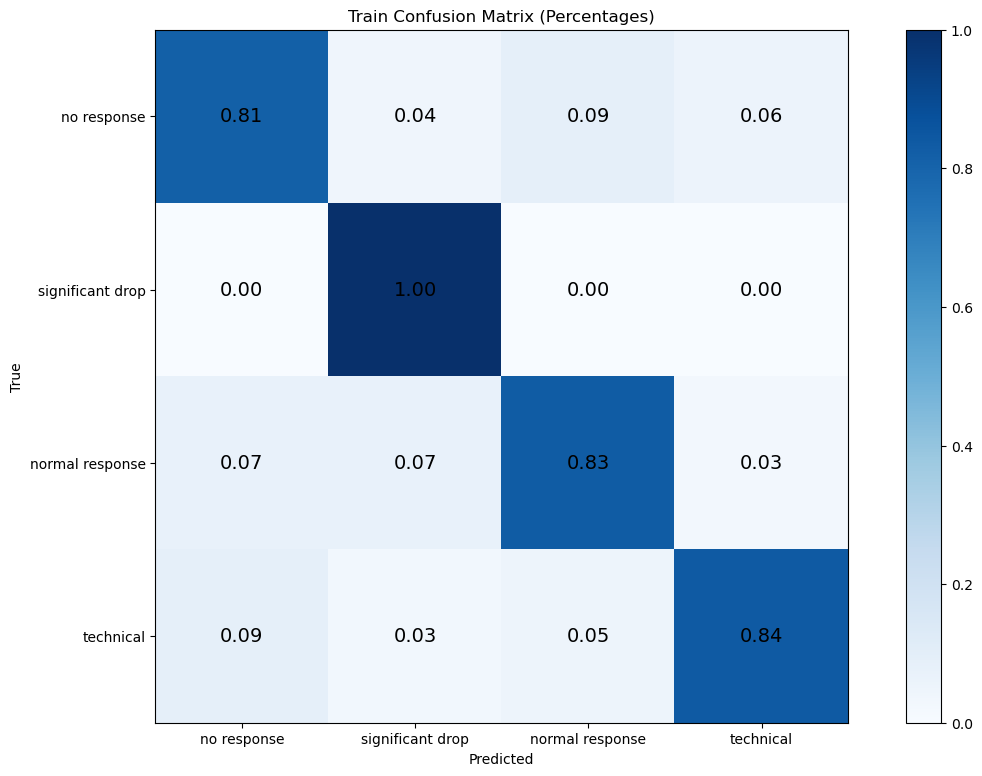

In [ ]:
# Present confusion matrix with unlabeled samples (second iteration)
torch.save(model.state_dict(), 'semi_supervised.pt') 
present_confusion_matrix(model,test_loader, 4, class_dict, is_train=False)
present_confusion_matrix(model,train_loader, 4, class_dict, is_train= True)

In [ ]:
# second time concatenating unlabeled data we classify with high confidence to labeled data
model.load_state_dict(torch.load('semi_supervised.pt'))
loaded_unlabeled_data = pd.read_pickle('SSEPLowerDataUnlabeled.pkl')
filtered_X_unlabeled = filter_set(loaded_unlabeled_data['values'].values)
filtered_baseline_unlabeled = filter_set(loaded_unlabeled_data['baseline_values'].values)
stft_unlabeled = get_set_stft(filtered_X_unlabeled)
diff_ulabeled = np.abs(filtered_X_unlabeled - filtered_baseline_unlabeled)
full_unlabeled_set = torch.stack((filtered_X_unlabeled, filtered_baseline_unlabeled, stft_unlabeled, diff_ulabeled), axis=1)
unlabeled_loader = DataLoader(full_unlabeled_set, batch_size=hparams.batch_size,num_workers=16)

threshold = 0.8
predicted_labels = []
samples = []

model.eval()
for batch in unlabeled_loader:
    batch = batch.to(device)
    output = model(batch)
    confidence, labels = torch.max(output, dim=1)
    # Filter by threshold
    high_conf_indices = (confidence > threshold).nonzero(as_tuple=True)[0]
    high_conf_labels = labels[high_conf_indices]
    high_conf_samples = batch[high_conf_indices]
    
    samples.append(high_conf_samples)
    predicted_labels.append(high_conf_labels)


In [ ]:
samples = torch.cat(samples, dim=0).cpu()
predicted_labels = torch.cat(predicted_labels, dim=0).cpu()
full_train_set = torch.stack((filtered_X_train, filtered_baseline_train, stft_X_train, diff_train), axis=1)
full_train_set = torch.cat((full_train_set, samples), axis=0)
y_full = torch.cat((torch.div(y_aug,2), predicted_labels), axis=0)
full_train_set_labeled = TensorDataset(full_train_set, y_full)

In [ ]:
# Define the model, optimizer, loss criterion and Scheduler and Data loaders
model = SSEPClassifier(input_size=(4,80,hparams.batch_size),channels=[512,256,128,64],hidden_dim=[16],output_size=4,p=hparams.dropout_probability).to(device) 
optimizer = optim.Adam(model.parameters(), lr=hparams.lr, weight_decay=hparams.weight_decay)

counts = torch.tensor([9245, 1784, 15425, 2835], dtype=torch.float)
total = counts.sum()
weights = total/counts
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
scheduler = optim.lr_scheduler.StepLR(optimizer, hparams.scheduler_step_size, hparams.scheduler_factor, verbose=False) 
train_loader = DataLoader(full_train_set_labeled,  batch_size=hparams.batch_size, num_workers=16, shuffle=True)
test_loader = DataLoader(full_test_set, batch_size=hparams.batch_size, num_workers=16, shuffle=True)

In [ ]:
# Number of samples the model predicted
print(samples.shape)  

torch.Size([17152, 4, 80])


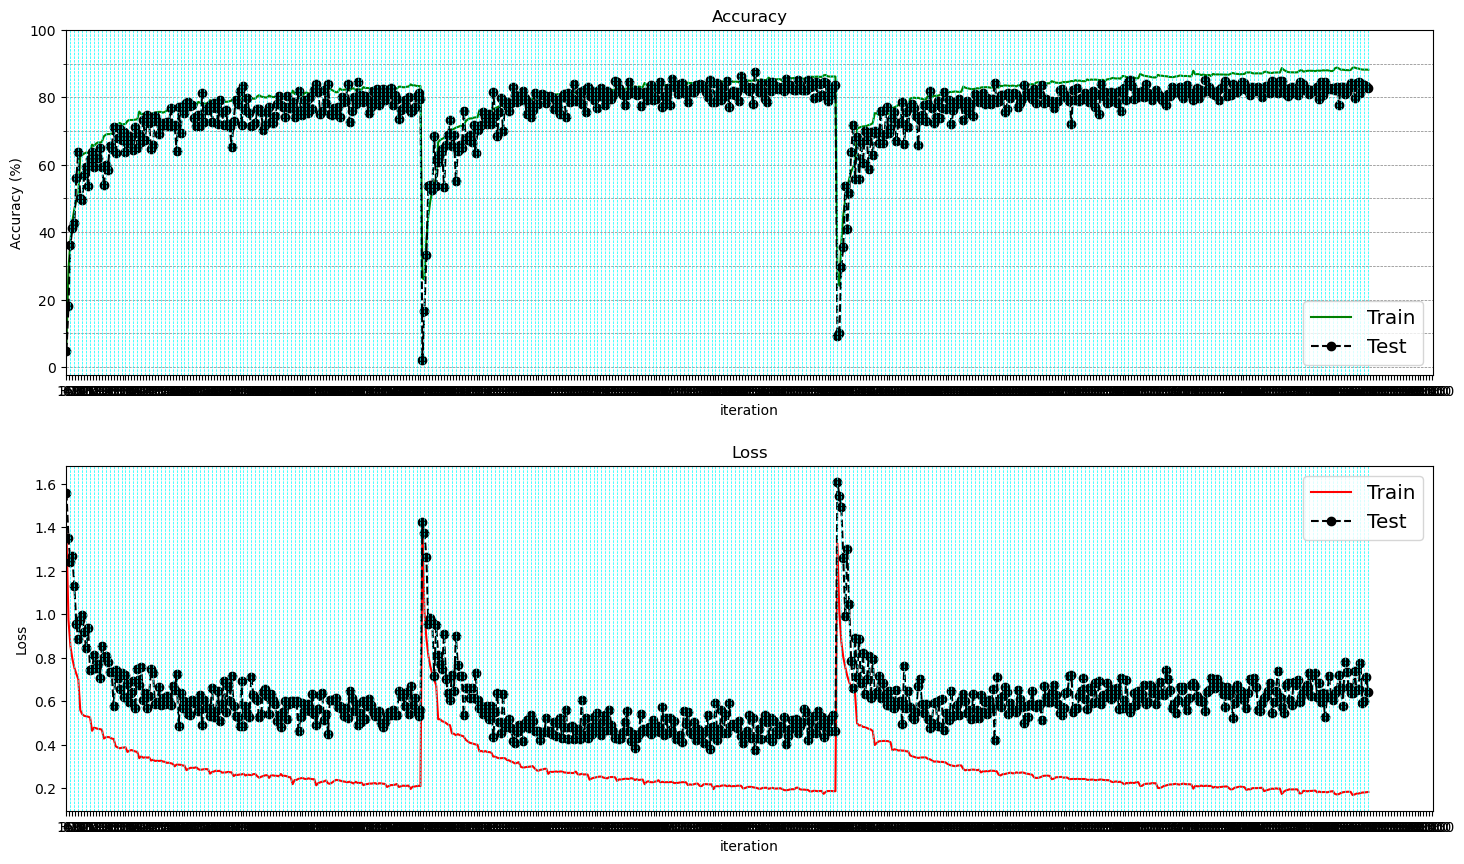

In [ ]:
# Third iteration - both unlabeled and labeled data
train_with_scheduler(hparams=hparams,train_loader=train_loader,test_loader=test_loader,model=model,optimizer=optimizer,scheduler=scheduler,criterion=criterion,acc_function=multi_class_accuracy)# to full writ

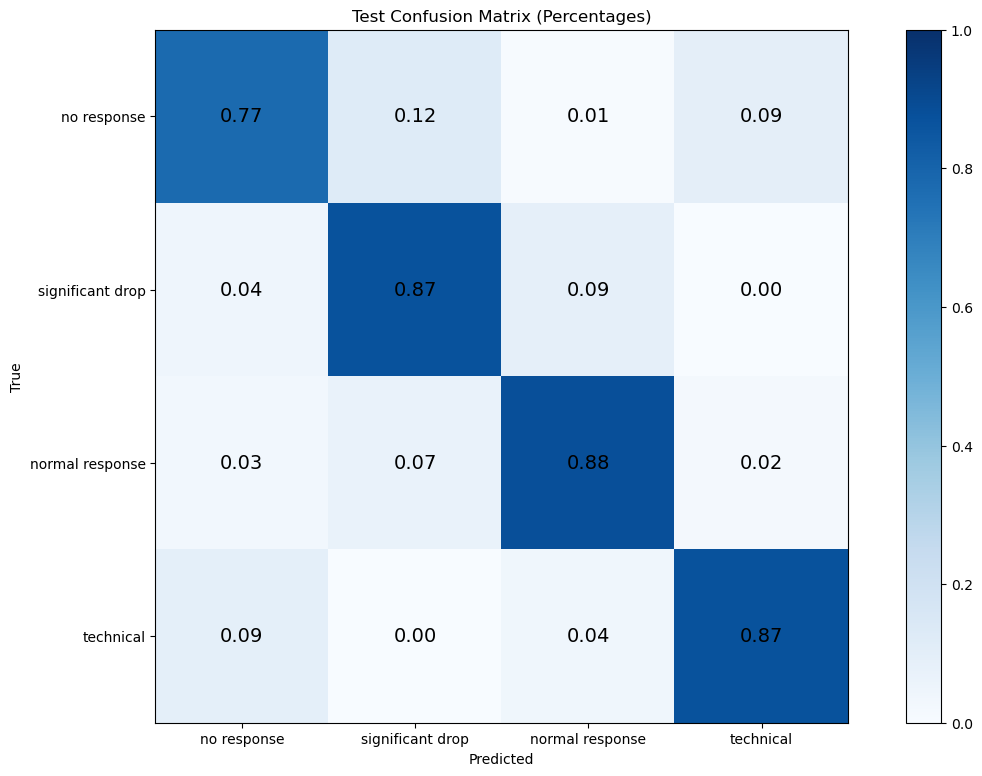

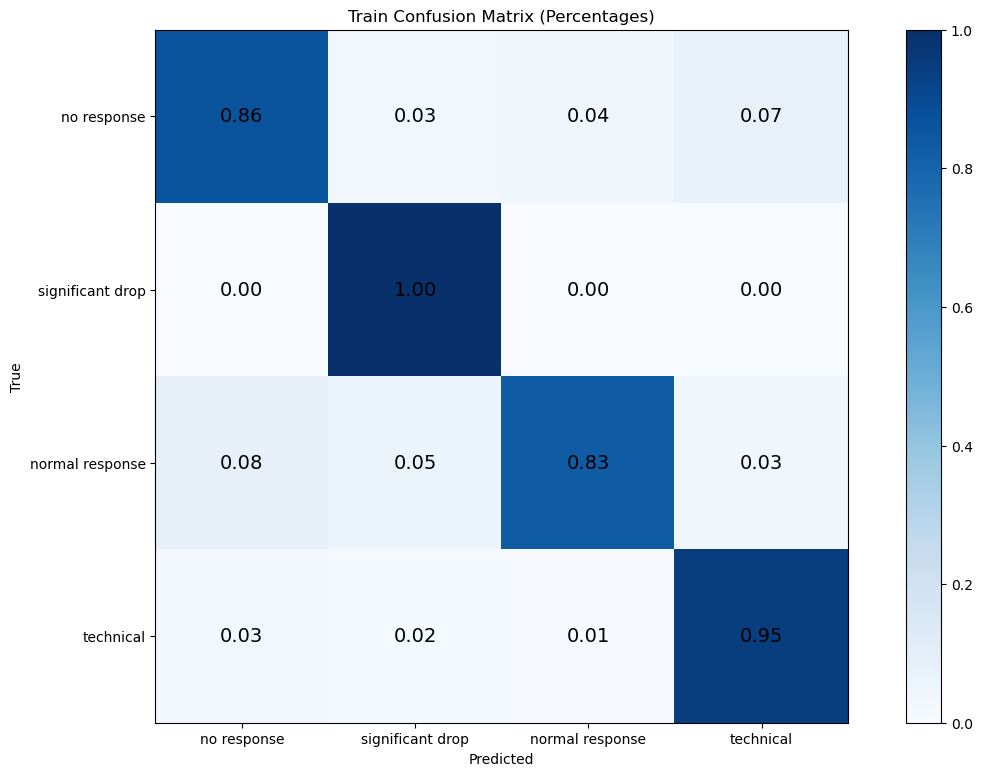

In [ ]:
# Present final confusion matrix with unlabeled samples (final iteration)
torch.save(model.state_dict(), 'semi_supervised_test.pt') # save with name adjusments
present_confusion_matrix(model,test_loader, 4, class_dict, is_train=False)
present_confusion_matrix(model,train_loader, 4, class_dict, is_train= True)

In [ ]:
# Calculate model's train and test overall accuracy
model.load_state_dict(torch.load('semi_supervised.pt'))

def compute_overall_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

train_acc = compute_overall_accuracy(model, train_loader, device)
test_acc = compute_overall_accuracy(model, test_loader, device)

print(f"Overall Train Accuracy: {train_acc:.2f}%")
print(f"Overall Test Accuracy: {test_acc:.2f}%")


Overall Train Accuracy: 84.35%
Overall Test Accuracy: 83.94%
